In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping  # used for convergence criteria
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Three function are defined below to create tables and graphs. These will make the comparison between models simple. 

def create_metric_table(models, train_history,changes,version_number):
    # Create a dataframe to store the model performance metrics
    metrics = pd.DataFrame(columns=["Model", "Optimizer", "Loss Function", "Learning Rate", "Num Hidden Layers", "Num Nodes per Layer", "Train Loss", "Val Loss", "Train Acc", "Val Acc"])

    # iterates through each model and retrieve its respective performance metric
    for i, model in enumerate(models): # enumerate function helps retrieve the model and its index
        optimizer = str(model.optimizer.__class__.__name__)
        loss_function = str(model.loss)
        α = model.optimizer.lr.numpy()
        num_hidden_layers = len(model.layers) - 2 # Subtracting input and output layers
        num_nodes_per_layer = [layer.output_shape[1] for layer in model.layers if hasattr(layer, 'output_shape')]
        train_loss = train_history[i].history["loss"][-1]
        val_loss = train_history[i].history["val_loss"][-1]
        train_acc = train_history[i].history["accuracy"][-1]
        val_acc = train_history[i].history["val_accuracy"][-1]
        
        # this adds the performance metrics (gathered above) to the metrics dataframe
        metrics.loc[i] = [f"Model {i+1}", optimizer, loss_function, α, num_hidden_layers, num_nodes_per_layer, train_loss, val_loss, train_acc, val_acc]

    print(f"\nModel Performance Metrics for {changes}:")
    
    # Saving the dataframe to a csv file in Google Drive (for the report)
    folder_path = "/content/drive/MyDrive/model_comparisons"
    file_name = f"metrics{version_number}.csv"
    file_path = folder_path + "/" + file_name
    metrics.to_csv(file_path, index=False)
    return metrics

def create_graphs(train_history,version_number):

    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'purple']
# STOPPED HERE
    # Plotting the model for training and validation loss
    plt.figure(figsize=(10, 5))
    for i, history in enumerate(train_history):
        plt.plot(history.history["loss"], color=colors[i], label=f"Model {i+1} Train Loss")
        plt.plot(history.history["val_loss"], '--', color=colors[i], label=f"Model {i+1} Val Loss")
    plt.title("Model Loss Comparison")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(ncol=2,fontsize='small')
    folder_path = "/content/drive/MyDrive/model_comparisons"
    file_name = f"loss{version_number}.png"
    file_path = folder_path + "/" + file_name
    plt.savefig(file_path, dpi=300)
    plt.show()
    plt.show()

    # plotting the model for training and validation accuracy.
    plt.figure(figsize=(10, 5))
    for i, history in enumerate(train_history):
        plt.plot(history.history["accuracy"], color=colors[i], label=f"Model {i+1} Train Acc")
        plt.plot(history.history["val_accuracy"], '--', color=colors[i], label=f"Model {i+1} Val Acc")
    plt.title("Model Accuracy Comparison")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(ncol=2,fontsize='small')
    #saving the graph in Google Drive
    file_name = f"accuracy{version_number}.png"
    file_path = folder_path + "/" + file_name
    plt.savefig(file_path, dpi=300)
    plt.show()

def compare_models(models, train_history,changes):
    version_number = '-'
    version_number += input('Please provide version number and change done')
    # create the table
    metric_table = create_metric_table(models, train_history,changes,version_number)
    print('')
    # Create the graphs.
    create_graphs(train_history,version_number)
    return metric_table

In [4]:
csv_file = "/content/drive/My Drive/Dataset/HIGGS_train.csv"  # path to csv

# Defining column names, Loading data
column_names = ["outcome"] + ["feature "+str(i) for i in range(1,29)]
df = pd.read_csv(csv_file, header=None, names=column_names)

# converting strings to float and removing rows with nan values. (pre-processing)
df = df.apply(pd.to_numeric, errors='coerce')
df = df.dropna()

<ipython-input-4-5184d83a31cf>:5: DtypeWarning: Columns (8,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file, header=None, names=column_names)


In [5]:
# Feature scaling
X_df = df.iloc[:, 1:]   # removes the output variable for preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df)
#print("After Scaling")
#print(np.mean(X_scaled, axis=0))
#print(np.std(X_scaled,axis=0))
df = pd.DataFrame(np.concatenate([df.iloc[:, :1].values, X_scaled], axis=1), columns=['outcome'] + list(df.columns[1:])) # merging

In [6]:
train_df, val_df, test_df = np.split(df.sample(frac=1, random_state=42), [int(0.6*len(df)), int(0.8*len(df))]) #splitting the data


In [7]:
# The code below is used to create a tensorflow dataframe with the training data. Prior to using this dataframe, the RAM would constantly overflow. With this dataframe, however,
# the RAM is far from overflowing. 


train_df, val_df, test_df = np.split(df.sample(frac=1, random_state=42), [int(0.6*len(df)), int(0.8*len(df))]) #splitting the data

# Creating tensors from the previous partitions, which will be used below to create the tensorflow dataset.
train_labels = tf.constant(train_df["outcome"].values)
train_features = tf.constant(train_df.drop("outcome", axis=1).values)
val_labels = tf.constant(val_df["outcome"].values)
val_features = tf.constant(val_df.drop("outcome", axis=1).values)
test_labels = tf.constant(test_df["outcome"].values)
test_features = tf.constant(test_df.drop("outcome", axis=1).values)

# Create TensorFlow datasets from the data (features are 1 column, train labels are the other column)
train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_features, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels))

#shuffling and batching the data.
batch_size = 32
train_buffer_size = tf.data.experimental.cardinality(train_dataset).numpy()   # setting buffer of the shuffle function to the maximum number of elements in the respective dataframe
val_buffer_size = tf.data.experimental.cardinality(val_dataset).numpy()
test_buffer_size = tf.data.experimental.cardinality(test_dataset).numpy()

train_dataset = train_dataset.shuffle(buffer_size=train_buffer_size)
train_dataset = train_dataset.batch(batch_size=batch_size)  # in this dataset, every element is a batch, which makes the code memory efficient

val_dataset = val_dataset.shuffle(buffer_size=val_buffer_size)
val_dataset = val_dataset.batch(batch_size=batch_size)

test_dataset = test_dataset.shuffle(buffer_size=test_buffer_size)
test_dataset = test_dataset.batch(batch_size=batch_size)

# prefetching the data that will be used after the current one. 
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)  #tf.data.AUTOTUNE allows tensorflow to automatically determine the right amount of buffer size for prefetch
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
num_elements = tf.data.experimental.cardinality(train_dataset).numpy()

In [9]:

# Number of batches in the tensor
num_datapoints = len(train_dataset)
print(num_datapoints)

11250


In [10]:
# first model
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),


    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

output_model1 = model_1.fit(train_dataset, validation_data=val_dataset, epochs=5,callbacks=[early_stopping])

Epoch 1/5
11250/11250 [==============================] - 21s 2ms/step - loss: 0.5752 - accuracy: 0.6944 - val_loss: 0.5488 - val_accuracy: 0.7164
Epoch 2/5
11250/11250 [==============================] - 21s 2ms/step - loss: 0.5403 - accuracy: 0.7231 - val_loss: 0.5314 - val_accuracy: 0.7296
Epoch 3/5
11250/11250 [==============================] - 22s 2ms/step - loss: 0.5296 - accuracy: 0.7294 - val_loss: 0.5284 - val_accuracy: 0.7313
Epoch 4/5
11250/11250 [==============================] - 21s 2ms/step - loss: 0.5228 - accuracy: 0.7343 - val_loss: 0.5221 - val_accuracy: 0.7342
Epoch 5/5
11250/11250 [==============================] - 20s 2ms/step - loss: 0.5178 - accuracy: 0.7371 - val_loss: 0.5180 - val_accuracy: 0.7367


In [11]:
# second model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

output_model2 = model_2.fit(train_dataset, validation_data=val_dataset, epochs=5,callbacks=[early_stopping])

Epoch 1/5
11250/11250 [==============================] - 23s 2ms/step - loss: 0.6026 - accuracy: 0.6693 - val_loss: 0.5709 - val_accuracy: 0.7004
Epoch 2/5
11250/11250 [==============================] - 21s 2ms/step - loss: 0.5633 - accuracy: 0.7056 - val_loss: 0.5583 - val_accuracy: 0.7086
Epoch 3/5
11250/11250 [==============================] - 19s 2ms/step - loss: 0.5539 - accuracy: 0.7128 - val_loss: 0.5525 - val_accuracy: 0.7135
Epoch 4/5
11250/11250 [==============================] - 20s 2ms/step - loss: 0.5481 - accuracy: 0.7160 - val_loss: 0.5447 - val_accuracy: 0.7178
Epoch 5/5
11250/11250 [==============================] - 21s 2ms/step - loss: 0.5443 - accuracy: 0.7182 - val_loss: 0.5449 - val_accuracy: 0.7185


In [12]:
# third model
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(28, activation='relu'),
    tf.keras.layers.Dense(18, activation='relu'),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

output_model3 = model_3.fit(train_dataset, validation_data=val_dataset, epochs=5,callbacks=[early_stopping])

Epoch 1/5
11250/11250 [==============================] - 21s 2ms/step - loss: 0.5899 - accuracy: 0.6811 - val_loss: 0.5604 - val_accuracy: 0.7089
Epoch 2/5
11250/11250 [==============================] - 21s 2ms/step - loss: 0.5498 - accuracy: 0.7159 - val_loss: 0.5437 - val_accuracy: 0.7212
Epoch 3/5
11250/11250 [==============================] - 22s 2ms/step - loss: 0.5395 - accuracy: 0.7234 - val_loss: 0.5372 - val_accuracy: 0.7243
Epoch 4/5
11250/11250 [==============================] - 21s 2ms/step - loss: 0.5338 - accuracy: 0.7276 - val_loss: 0.5322 - val_accuracy: 0.7292
Epoch 5/5
11250/11250 [==============================] - 20s 2ms/step - loss: 0.5300 - accuracy: 0.7300 - val_loss: 0.5319 - val_accuracy: 0.7289


In [13]:
# fourth model
model_4 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

output_model4 = model_4.fit(train_dataset, validation_data=val_dataset, epochs=5,callbacks=[early_stopping])

Epoch 1/5
11250/11250 [==============================] - 24s 2ms/step - loss: 0.5703 - accuracy: 0.6985 - val_loss: 0.5422 - val_accuracy: 0.7215
Epoch 2/5
11250/11250 [==============================] - 23s 2ms/step - loss: 0.5364 - accuracy: 0.7254 - val_loss: 0.5357 - val_accuracy: 0.7255
Epoch 3/5
11250/11250 [==============================] - 22s 2ms/step - loss: 0.5251 - accuracy: 0.7334 - val_loss: 0.5240 - val_accuracy: 0.7350
Epoch 4/5
11250/11250 [==============================] - 22s 2ms/step - loss: 0.5172 - accuracy: 0.7379 - val_loss: 0.5236 - val_accuracy: 0.7372
Epoch 5/5
11250/11250 [==============================] - 24s 2ms/step - loss: 0.5122 - accuracy: 0.7415 - val_loss: 0.5218 - val_accuracy: 0.7329


In [14]:
model_5 = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

output_model5 = model_5.fit(train_dataset, validation_data=val_dataset, epochs=5, callbacks=[early_stopping])


Epoch 1/5
11250/11250 [==============================] - 29s 2ms/step - loss: 0.5632 - accuracy: 0.7049 - val_loss: 0.5420 - val_accuracy: 0.7198
Epoch 2/5
11250/11250 [==============================] - 25s 2ms/step - loss: 0.5300 - accuracy: 0.7302 - val_loss: 0.5243 - val_accuracy: 0.7315
Epoch 3/5
11250/11250 [==============================] - 27s 2ms/step - loss: 0.5185 - accuracy: 0.7376 - val_loss: 0.5199 - val_accuracy: 0.7384
Epoch 4/5
11250/11250 [==============================] - 27s 2ms/step - loss: 0.5112 - accuracy: 0.7426 - val_loss: 0.5178 - val_accuracy: 0.7392
Epoch 5/5
11250/11250 [==============================] - 26s 2ms/step - loss: 0.5052 - accuracy: 0.7466 - val_loss: 0.5118 - val_accuracy: 0.7423


In [15]:
list_models = [model_1,model_2,model_3,model_4,model_5]
list_output_models = [output_model1,output_model2,output_model3,output_model4,output_model5]

Please provide version number and change doneadded-nodes-25-03

Model Performance Metrics for changes in the number of nodes in each hidden layer:



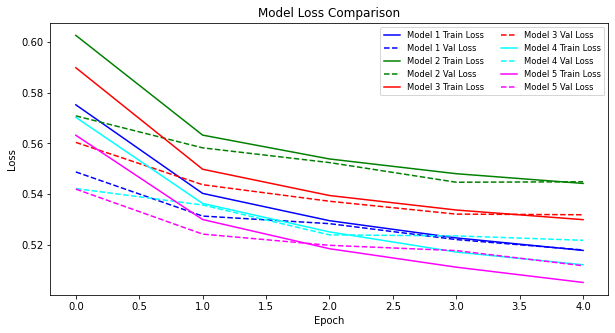

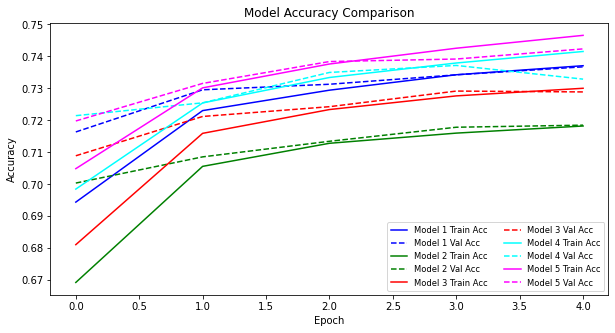

,Model,Optimizer,Loss Function,Learning Rate,Num Hidden Layers,Num Nodes per Layer,Train Loss,Val Loss,Train Acc,Val Acc
0,Model 1,Adam,binary_crossentropy,0.001,3,"[64, 32, 32, 32, 1]",0.517838,0.518022,0.737087,0.736731
1,Model 2,Adam,binary_crossentropy,0.001,3,"[12, 12, 12, 12, 1]",0.544254,0.544899,0.718231,0.718498
2,Model 3,Adam,binary_crossentropy,0.001,3,"[28, 18, 12, 6, 1]",0.529966,0.531897,0.730031,0.728889
3,Model 4,Adam,binary_crossentropy,0.001,3,"[128, 64, 32, 6, 1]",0.512183,0.521826,0.741534,0.732889
4,Model 5,Adam,binary_crossentropy,0.001,3,"[256, 128, 64, 32, 1]",0.505214,0.511797,0.746578,0.742348


In [17]:
compare_models(list_models, list_output_models, "changes in the number of nodes in each hidden layer")

In [ ]:
# testing for accuracy 
loss, accuracy = model_1.evaluate(test_dataset)

print("Test loss:", loss)
print("Test accuracy:", accuracy)


3750/3750 [==============================] - 5s 1ms/step - loss: 0.5231 - accuracy: 0.7356
Test loss: 0.5230982303619385
Test accuracy: 0.7356416583061218
